In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

In [2]:
def compose(*functions):
  """
  My own compose function because itertools doesn't have one
  and I'm a functional programming shill.
  """
  def inner(*args, **kwargs):
    res = functions[-1](*args, **kwargs)
    for f in functions[-2::-1]:
      res = f(res)
    return res
  return inner

In [3]:
data = pd.read_csv('./real_data.csv')
print(data.head)

<bound method NDFrame.head of        Unnamed: 0  jatosStudyResultId    sub_id studentnumber  Block_nr  ITI  \
0               1              181910  pp181910      s5337712         0  638   
1               2              181910  pp181910      s5337712         0  700   
2               3              181910  pp181910      s5337712         0  624   
3               4              181910  pp181910      s5337712         0  594   
4               5              181910  pp181910      s5337712         0  520   
...           ...                 ...       ...           ...       ...  ...   
29200       29201              186001  pp186001      s2731517        16  552   
29201       29202              186001  pp186001      s2731517        16  585   
29202       29203              186001  pp186001      s2731517        16  514   
29203       29204              186001  pp186001      s2731517        16  747   
29204       29205              186001  pp186001      s2731517        16  756   

      pra

In [4]:
def preprocess(data, extra_filter = ""):
  """
  Gets rid of practice, outlier, bad submission, and incomplete trial rows.
  Allows for additional filters. For example: "correct == 'yes' and Block_nr > 5".
  """
  if extra_filter:  # True if it's not the empty string
    extra_filter = " and " + extra_filter

  filter_expression = """
    practice == 'no'      and
    outlier  == 'no'      and
    good_sub == True      and
    exp_completed == True 
  """
  filter_expression = (filter_expression + extra_filter).replace('\n', '')

  return data.query(filter_expression)

data = preprocess(data)
print(data.head())

    Unnamed: 0  jatosStudyResultId    sub_id studentnumber  Block_nr  ITI  \
15          16              181910  pp181910      s5337712         1  608   
16          17              181910  pp181910      s5337712         1  745   
17          18              181910  pp181910      s5337712         1  576   
18          19              181910  pp181910      s5337712         1  600   
19          20              181910  pp181910      s5337712         1  515   

   practice  foreperiod reward target_visibility  ...   FP fp_1  fp_2 fp_3  \
15       no         300    yes                hi  ...  300  0.9   0.3  0.6   
16       no         300    yes                hi  ...  300  0.3   0.9  0.3   
17       no         300    yes                hi  ...  300  0.3   0.3  0.9   
18       no         600    yes                hi  ...  600  0.3   0.3  0.3   
19       no         900    yes                hi  ...  900  0.6   0.3  0.3   

   fp_4  fp_5   RT     invRT  outlier  good_sub  
15  0.3   0.6  345

In [7]:
def aggregate(data, columns, ndarray=True):
  """
  Calculates the means and standard deviations of the target variable (i.e. the first in the list of columns)
  for all conditions (i.e. all other columns).
  
  Example call:
  means, labels = aggregate(data, ['RT', 'FP', 'reward', 'target_visibility'])
  
  Will return a 4D list, indexed on target_visibilty first, then reward, then FP.
  At which point you'll access a numpy array of the mean and std of RT, of length 2 of course.
  """
  
  target_name = columns[0]
  # Column names of the conditional variables. Without the first (i.e. target) column and reversed.
  condition_names = columns[:0:-1] 
  
  # All unique values per conditional column. e.g. [[300, 600, 900], ['yes', 'no']].
  original_unique_values = [data[col].unique() for col in condition_names]
  # Strings require to be surrounded by additional quotation marks when using a dataframe query.
  unique_values = [list(map(format_val, val)) for val in original_unique_values]
  
  # N-dimensional output array. Where N is the number of conditional variables, plus one for the target variable.
  target_values = np.zeros(list([*map(len, unique_values), 3]))
  
  # Loop over all combinations of conditional variable values.
  for value_idxs, col_values in zip(it.product(*map(compose(range, len), unique_values)), 
                                    it.product(*unique_values)):
    
    # Filter dataframe on the specific value combination. e.g. "FP == 300 and reward == 'no'".
    filter_expression = " and ".join([f"{col} == {val}" for col, val 
                                      in zip(condition_names, col_values)])
    
    subset = data.query(filter_expression)
    mean = np.mean(subset[target_name])
    std = np.std(subset[target_name])
    n_samples = len(subset)
    
    # Record the mean, standard deviation, and nr. of samples in output array.
    target_values[value_idxs] = np.array([mean, std, n_samples])
  
  
  label_dict = {col: list(original_unique_values[i]) for i, col in enumerate(condition_names)}
  # Append output column name for plot labeling later on.
  label_dict = {**label_dict, target_name: []}
  
  if ndarray:
    return target_values, label_dict
  
  return ndarray_to_df(target_values, label_dict)


def format_val(value):
  """
  For dataframe queries, string values need to be surrounded by additional quotation marks.
  This function ensures that only strings are formatted as such, and nothing else.
  """
  if not isinstance(value, str) or value.isnumeric() or value in ['True', 'False']:
    return value
  return f"'{value}'"


def ndarray_to_df(ndarray: np.ndarray, labels):
  """
  Converts pandas dataframe to ndarray + label dict.
  """
  condition_names = list(labels.keys())[:-1]
  target = list(labels.keys())[-1]
  target_names = [f"{target}_{metric}" for metric in ["mean", "std", "N"]]
  condition_values = list(labels.values())[:-1]
  
  df_values = [list(cond_value_combo) + list(target_values)
                 for cond_value_combo, target_values
                 in zip(it.product(*condition_values), ndarray.reshape(-1, ndarray.shape[-1]))]
  df = pd.DataFrame(df_values, columns = condition_names + target_names)

  return df


def df_to_ndarray(df: pd.DataFrame):
  """
  Converts ndarray + label dict format into pandas dataframe.
  """
  condition_names = list(df.columns)[:-3]
  target_name = '_'.join(df.columns[-1].split('_')[:-1])
  condition_values = [df[cond].unique() for cond in condition_names]
  
  ndarray_shape = (*map(len, condition_values), 3)
  ndarray = np.array(df.iloc[:, -3:]).reshape(ndarray_shape)
  
  label_dict = dict(zip(condition_names + [target_name], list(map(list, condition_values + [[]]))))
  
  return ndarray, label_dict
  
  
ndarray_output_format = True

output = aggregate(data, ['RT', 'FP', 'reward', 'target_location'], ndarray=ndarray_output_format)

if ndarray_output_format:
  target_values, label_dict = output
  print(target_values)
  print(f"labels: {label_dict}")

  print("\nMean and std of first entry:")
  # Accessing via values
  print(target_values[label_dict['target_visibility'].index('hi'),
                      label_dict['reward'].index("yes"),
                      label_dict['FP'].index(300)])

  # Accessing via indices directly
  print(target_values[0,0,0])

else:
  means_df = output
  print(means_df)

[[[[ 321.00868056   62.5487651  2304.        ]
   [ 301.68798956   54.44892565 2298.        ]
   [ 297.1045235    55.73353665 2277.        ]]

  [[ 332.20236531   69.2321142  2283.        ]
   [ 315.0377193    67.34578471 2280.        ]
   [ 307.11640212   62.19653406 2268.        ]]]


 [[[ 320.10629067   60.5527502  2305.        ]
   [ 304.01921397   62.30528851 2290.        ]
   [ 297.89531802   51.37950409 2264.        ]]

  [[ 330.17425569   69.20312194 2284.        ]
   [ 312.94813187   61.6365379  2275.        ]
   [ 306.33171806   59.99562105 2270.        ]]]]
labels: {'target_location': ['left', 'right'], 'reward': ['yes', 'no'], 'FP': [300, 600, 900], 'RT': []}

Mean and std of first entry:


KeyError: 'target_visibility'

/tmp/ipykernel_16290/359738171.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


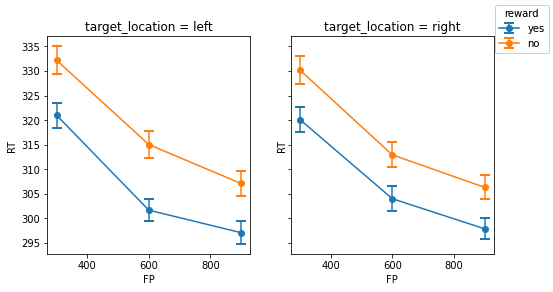

In [10]:
def means_plot(target_values, label_dict):
  n_dims = len(target_values.shape)
  
  assert n_dims < 5, f"Can only plot up to 4D data. Provided array is {n_dims}D."
  
  dims = list(target_values.shape)
  # Prepend 1 to list of dimensions untiil it has a length of 4.
  # Done to allow generalization of the following code.
  dims = ([1] * (4 - n_dims)) + dims
  
  target_values = target_values.reshape(dims)
  
  condition_names = list(label_dict.keys())
  condition_values = list(label_dict.values())
  
  n_plots, n_graphs, x_dim, y_dim = dims
  
  # Calculate the optimal nr. of rows and columns in the multiplot to.
  # i.e. as close to a square as possible, with as little empty axes.
  n_rows = compose(int, np.round, np.sqrt)(n_plots)
  n_cols = compose(int, np.ceil, np.sqrt)(n_plots)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True)
  
  # Loop over the nr. of axes (i.e. sub plots).
  for plot_idx, ax in enumerate(np.ravel(axes)[:n_plots]):
    x_vals = condition_values[-2]
    
    # Loop over the nr. of graphs (i.e. lines).
    for graph_idx in range(n_graphs):
      # Retrieve / calculate the target means and 95% confidence intervals.
      y_means = target_values[plot_idx, graph_idx, :, 0]
      y_std = target_values[plot_idx, graph_idx, :, 1]
      n_samples = target_values[plot_idx, graph_idx, :, 2]
      y_error = 1.96 * y_std / np.sqrt(n_samples)  # 1.96 * std to get the 95% confidence interval
      
      # Append label to the legend only if there are multiple graphs and we're currently on the first subplot.
      label = "" if n_graphs == 1 or plot_idx > 0 else condition_values[-3][graph_idx]
      
      ax.errorbar(x_vals, y_means, y_error, marker='o', label=label, capsize=5, capthick=2)
    
    # Check if we need multiple graphs.
    # Create legend containing labels for each graph if so.
    if n_graphs > 1:
      fig.legend(title=condition_names[-3]) 
    
    # Check if we need multiple subplots/axes. Assign titles to each subplot if so.
    if n_plots > 1:
      title = f"{condition_names[-4]} = {condition_values[-4][plot_idx]}"
      ax.set_title(title)   
      
    ax.set_xlabel(condition_names[-2])
    ax.set_ylabel(condition_names[-1])
  
  return fig, axes
  
fig, axes = means_plot(target_values, label_dict)
# fig.set_figheight(5)
# fig.set_figwidth(10)
fig.show()

## One last usage example without all of the function definitions:

/tmp/ipykernel_16290/3970606013.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


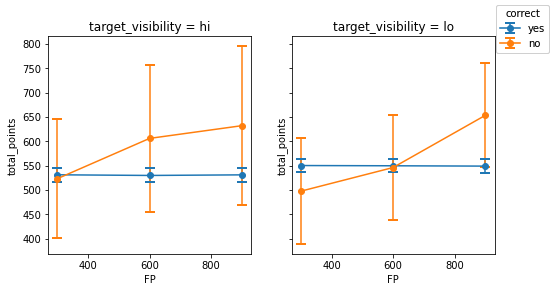

In [12]:
data = pd.read_csv('./real_data.csv')
data = preprocess(data)

target_values, label_dict = aggregate(data, ['total_points', 'FP', 'correct', 'target_visibility'], ndarray=True)

# Practically useless application of conversion functions.
# Just wanted to show you can use these.
df = ndarray_to_df(target_values, label_dict)
target_values, label_dict = df_to_ndarray(df)

fig, axes = means_plot(target_values, label_dict)
fig.show()